# Assignment 2.2: Genome assembly

# Learning outcomes
To get:
- Familiarity with $k$-mer-based genome assembly (i.e. de Bruijn graphs)
- A practical understanding of contig assembly based on unitigs (including the benefits of error correction)
- A basic knowledge about evaluating assembly results
- An understanding that non-trivial algorithms are required for great practical results (not always, but often)

# Contents
### 1. Basics on de Bruijn graphs
    1.1 Construction
    1.2 Traversal
    1.3 Visualization

### 2. Contig assembly
    2.1 Unitig assembly
    2.2 Assembly of high-throughput sequencing reads

### 3. Evaluating assembly results
    3.1. Numerical statistics
    3.2. Visual statistics

### 4. Error handling
    4.1. Validation
    4.2. Correction

---
$^\ast$The algorithms and datasets in this assignment assume a simplified scenario: the genome is single stranded (i.e., no reverse complements), it is small (ebola virus, 20K bases), every $k$-mer in the genome is sequenced. Moreover, reads have length 100, coverage 20x, and their error rate is 0.75%.

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 0</strong></h3>

At the end of the assignment, write here how many hours it took to complete it (approximately). Write also general feedback about the assignment. What was difficult, what was easy, what was interesting, what was not, what other tasks / topics you would have liked to have in it?

---

#### Hours used for the tasks
I would estimate I spent about 8 hours doing these tasks. And the some more when I thought I had made a mistake but turned out that I had not.



---

#### My background
Mathematics with a computer science minor.

---

# 1. Basics on de Bruijn graphs

In this section you will develop the main functionality of a de Bruijn graph. 

The de Bruijn graph will be represented as a Python dictionary containing the $k$-mers of the graph. (Given the large amount of data from a sequencing experiment, state-of-the-art genome assemblers use more advanced data structures, and an optimized implementation in C++ for example.)

## 1.0 A note on edge-centric / node-centric de Bruijn graphs

Recall that during the lecture we added an edge between two $k$-mers if there was also a $(k+1)$-mer supporting the edge. This is called an *edge-centric* de Bruijn graph. 

In this assignment, for simplicity, we will work instead with *node-centric* de Bruijn graphs, where we add an edge whenever there is a suffix-prefix overlap of length $k-1$ between the two $k$-mers (i.e., the $(k+1)$-mer spelled by the edge doesn't need to be present in the reads).

## 1.1. Construction

We will begin with a simple example: we construct the de Bruijn graph based on all the $k$-mers in a *single* string `genome`. We also initialize a list of all DNA characters.

In [2]:
dnaBases = ['A','C','G','T']
genome = 'ACGATCGTTC'

The de Bruijn graph built from all $3$-mers of the above string ``genome`` will be this one: <img src='data/testDBGraph.svg'>

Let's construct it with the function `build_dbGraph_from_string` below. We loop through the $k$-mers of the input string and add them to `dbGraph`. In this assignment, by "adding", we mean that we add the corresponding $k$-mer to the dictionary `dbGraph` with value 1. We'll use those values latter for describing *abundancies*.

In [3]:
def build_dbGraph_from_string(string, order):
    dbGraph = dict()
    for i in range(len(string) - (order-1)):
        kmer = string[i:i+order]
        dbGraph[kmer] = 1
    return dbGraph

k = 3 # This is the order of our test de Bruijn graph 
test_dbGraph = build_dbGraph_from_string(genome, k)

print(test_dbGraph)

{'ACG': 1, 'CGA': 1, 'GAT': 1, 'ATC': 1, 'TCG': 1, 'CGT': 1, 'GTT': 1, 'TTC': 1}


## 1.2. Traversal

We now implement a function that will give us the out-neighbors of a given node (i.e., of a given $k$-mer) in the de Bruijn graph.

Consider first three helper functions on strings (and $k$-mers).

In [4]:
def nextKmer(kmer, newBase):
    return kmer[1:] + newBase

def prevKmer(kmer, newBase):
    return newBase + kmer[:-1]

def merge_strings(s, kmer):
    return s + kmer[-1]

print('Next kmer for "GAT" and "C" is:', nextKmer('GAT', 'C'))
print('Previous kmer for "GAT" and "C" is:', prevKmer('GAT', 'C'))
print('The merge of "ACGAT" and "ATC" is:', merge_strings('ACGAT','ATC'))

Next kmer for "GAT" and "C" is: ATC
Previous kmer for "GAT" and "C" is: CGA
The merge of "ACGAT" and "ATC" is: ACGATC


<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 1</strong></h3>

Explain what the three functions above do.

---
#### nextKmer


Takes string parameters kmer and newBase and returns the concatenation of kmer without the first character and newBase.

**Less technically**, we give the function a kmer (string of length k) and newBase (string of length 1) and return the next kmer (string length k) given the next base to come is newBase.


#### prevKmer
Takes string parameters kmer and newBase and returns the concatenation of newBase and kmer without the last character.

**Less technically**, we give the function a kmer (string of length k) and newBase (string of length 1) and return the previous kmer (string length k) given the previous base has been newBase.


#### merge_strings
Takes string parameters s and kmer and returns the concatenation of s and the last character of kmer.

**Less technically**, we give the function a sequence (s) and kmer and return the sequence merged with the kmer. The matching part (assumed to be k-1 last bases of s and k-1 first bases of kmer) is removed from kmer and only the last base added to s.

---

We now implement a function which, given a de Bruijn graph `graph` and a string `kmer`, returns the list of out-neighbors of `kmer`. This  works by enumerating through the list `dnaBases`, considers the function `nextKmer` applied to `kmer` over each such DNA base, and checks whether this possible next kmer is an element of the dictionary `graph`. To check if a kmer `s` is an element in the keys of the dictionary `graph`, we use `if s in graph:`.

In [5]:
def out_neighbors(graph, kmer):
    n = list() # The list of out-neighbors
    for base in dnaBases:
        nKmer = nextKmer(kmer, base)
        if nKmer in graph:
            n.append(nKmer)
            
    return n

print(out_neighbors(test_dbGraph, 'ACG'))

['CGA', 'CGT']


<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 2</strong></h3>

It is your job now to implement the symmetric function returning the list of in-neighbors of a given `kmer` in `test_dbGraph`. **Hint**: Use exactly the same code as in `out_neighbors` but using the function `prevKmer` instead.

In [6]:
def in_neighbors(graph, kmer):
    n = list() # The list of in-neighbors
    for base in dnaBases:
        nKmer = prevKmer(kmer, base)
        if nKmer in graph:
            n.append(nKmer)
            
    return n

print(in_neighbors(test_dbGraph, 'CGA'))

['ACG', 'TCG']


## 1.3. Visualization

Having the dictionary `dbGraph` and the function `out_neighbors`, we have the basic functionality of a de Bruijn graph. As a sanity check of the implementation, we can visualize our de Bruijn graph constructed from `genome`. We do this with the **graphviz** package (using the `dot` representation). Make sure the graph you obtain is the same as the one shown above.


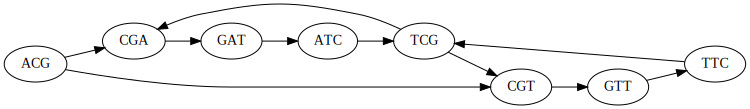

In [7]:
from graphviz import Digraph

def get_dot_representation(graph):
    dot = Digraph()
    dot.graph_attr['rankdir'] = 'LR' # Display the graph in landscape mode

    for key in graph:
        kmer = key
        dot.node(kmer) 
        for neighbor in out_neighbors(graph, kmer):
            dot.edge(kmer, neighbor) 
     
    return dot
    

dot_representation = get_dot_representation(test_dbGraph)
dot_representation

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 3</strong></h3>

Explain how the above code works.

---
#### get_dot_presentation
First a dot graph with desired display mode is created using Digraph. Then the keys (kmers) in graph (given as parameter) is looped through and each key (kmer) is added to the dot graph. Then the list of out neaighbors (given by function out_neighbors) is looped through and an edge is added between the key (kmer) and each neighbor. Finally, the funtion returns this dot graph.

---

# 2. Contig assembly

## 2.1. Unitig assembly

Recall that in class we said that a node is the first node of some unitig if its number of in-neighbors is different from $1$ or if its number of out-neighbors is different from $1$. Also, the start of a unitig must have at least $1$ out-neighbor.

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 4</strong></h3>

Implement the following function. **Hint**: Use the functions `in_neighbors` and `out_neighbors` implemented above.

In [86]:
def is_start_of_unitig(graph, kmer):
    # Returns True if and only if kmer is the first node of some unitig in graph
    is_start = False
    out_n = len(out_neighbors(graph, kmer))
    in_n = len(in_neighbors(graph, kmer))
    if out_n != 1:
        is_start = True
    if in_n != 1:
        is_start = True
    if out_n == 0:
        is_start = False
    
    return is_start

Recall that we say that a path $U = (v_1,v_2,\dots,v_t)$ is a *unitig* if either
- $t = 2$, that is, $U = (v_1,v_2)$ is a single edge, or
- $t > 2$ and for all $i \in \{2,\dots,t-1\}$, it holds that $v_i$ has only one in-neighbor (in this case, $v_{i-1}$) and only one out-neighbor (in this case, $v_{i+1}$).

Given a node `firstKmer` and one of its out-neighbors, `secondKmer`, the following function traverses the path starting with the edge `(firstKmer,secondKmer)` as long as it is a unitig. While doing so, it extends the current string `unitig` by merging to it the unique out-neighbor `nextKmer`. See the image below, where the nodes of the unitig are shown in green.

<img src='data/unitig-1.png'>

In [15]:
def assemble_unitig_starting_with(graph, firstKmer, secondKmer):
    unitig = merge_strings(firstKmer,secondKmer)
    o_neighbors = out_neighbors(graph,secondKmer)
    i_neighbors = in_neighbors(graph,secondKmer)
    while len(o_neighbors) == 1 and len(i_neighbors) == 1:
        nextKmer = o_neighbors[0]
        unitig = merge_strings(unitig,nextKmer)
        o_neighbors = out_neighbors(graph,nextKmer)
        i_neighbors = in_neighbors(graph,nextKmer)
    return unitig

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 5</strong></h3>

Explain in your own words the code above.

---
#### assemble_unitig_starting_with
The function takes graph, firsKmer and secondKmer as parameters. The start of the unitig is formed by merging the firstKmer and secondKmer with the merge_strings function. Out and in neighbors of secondKmer are saved in variables o_neighbors and in_neighbors. While loop is entered if the number of out and in neighbors are both 1. Variable nextKmer is defined to be the only out neighbor of secondKmer and that is merged into the unitig using the merge_strings function. Values of variables o_neighbors ans i_neighbors are updated to contain the neighbors of nextKmer. While loop starts over and again we enter if both number of out and in neighbor is equal to 1 and the process starts over. If there are more than 1 out or in neighbor (meaning the end of a unitig has been reached), the loop is exited and so far accumulated unitig returned.

---

We now have the two main ingredients of the algorithm finding all unitigs of the graph. Let's put them to work. We enumerate through all keys (i.e. $k$-mers) of the dictionary graph (`for kmer in graph:`) , for each such $k$-mer we test if it is the start of some unitig, and if so, we enumerate all its out-neighbors, and call the function `assemble_unitig_starting_with` with the $k$-mer and its out-neighbor as parameters. See the image below. 

<img src='data/unitig-2.png'>

In [16]:
def assemble_unitigs(graph):
    unitigs = list()

    for kmer in graph:
        if is_start_of_unitig(graph, kmer):
            for neighbor in out_neighbors(graph, kmer):
                unitig = assemble_unitig_starting_with(graph, kmer, neighbor)
                unitigs.append(unitig)
    
    return unitigs

Check that the unitigs you get for `test_dbGraph` are the correct ones, by looking at the visualization of the graph.

['ACGA', 'ACGT', 'CGATCG', 'TCGA', 'TCGT', 'CGTTCG']


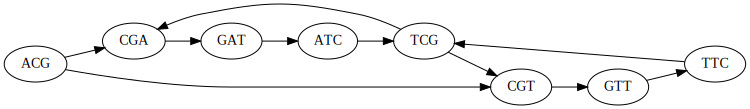

In [17]:
test_unitigs = assemble_unitigs(test_dbGraph)
print(test_unitigs)
dot_representation = get_dot_representation(test_dbGraph)
dot_representation

## 2.2. Assembly of high-throughput sequencing reads

The graph `test_dbGraph` was built from a single genomic string. We now build a graph from the reads in a *FASTQ* file. First, we implement the following function that gets the reads. We remove the new line character from the end of each line (with `str.strip()`), and for convention, we convert all characters in the reads to uppper case (with `str.upper()`).

In [18]:
def get_reads(filePath):
    reads = list() # The list of strings that will store the reads (the DNA strings) in the FASTQ file at filePath
    fastqFile = open(filePath, 'r') 
    fastqLines = fastqFile.readlines() 
    fastqFile.close()

    for lineIndex in range(1, len(fastqLines), 4):
        line = fastqLines[lineIndex]
        reads.append(line.strip().upper())
        
    return reads

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 6</strong></h3>

Explain what is the purpose of the line `for lineIndex in range(1, len(fastqLines), 4):`.

---
#### lineIndex in range(1, len(fastgLines), 4)
This line creates a loop over every 4th line listed in fastqLines starting from the second line.

---

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 7</strong></h3>

You now have to write a function equivalent to `build_dbGraph_from_string`, which however builds the graph from a collection of strings.

In [92]:
def build_dbGraph_from_reads(reads, order):
    dbGraph = dict()
    for read in reads:
        graph_from_read = build_dbGraph_from_string(read, order)
        dbGraph.update(graph_from_read)

    return dbGraph

With the above two functions in hand, we can build our de Bruijn graph from the reads in `reads.fastq`. For now, we will use the order `k = 15`.

In [97]:
k = 15
reads = get_reads('data/reads.fastq')
dbGraph = build_dbGraph_from_reads(reads, k)

unitigs = assemble_unitigs(dbGraph)

print('Assembled', len(unitigs), 'unitigs')

Assembled 7905 unitigs


# 3. Evaluating assembly results

With our unitigs in hand, we now try to get an idea of how good are these assembly results. 

## 3.1. Numerical statistics

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 8</strong></h3>

Implement a function that prints the mean, median, minimum and maximum values of the list of unitig lengths. Print also the number of unitigs, and the total length of all unitigs. *Hint*: use the Python package **statistics**, and the Python built-in functions **min(list)**, **max(list)** and **sum(list)**.

In [28]:
import statistics

def print_basic_statistics(unitigs):

    unitig_lengths = [len(unitig) for unitig in unitigs]

    mean = statistics.mean(unitig_lengths)
    median = statistics.median(unitig_lengths)
    minimum = min(unitig_lengths)
    maximum = max(unitig_lengths)
    totalLength = sum(unitig_lengths)
    
    print('Mean unitig length:', mean)
    print('Median unitig length:', median)
    print('Min unitig length:', minimum)
    print('Max unitig length:', maximum)
    print('Number of unitigs:', len(unitigs))
    print('Total length of unitigs:', totalLength)

print_basic_statistics(unitigs)

Mean unitig length: 22.161163820366856
Median unitig length: 20
Min unitig length: 16
Max unitig length: 45
Number of unitigs: 7905
Total length of unitigs: 175184


Another measure of how contiguous an assembly is, is the N50 value. This is defined as the greatest unitig length $N$ such that the unitigs of length $\geq N$ have sum of lengths at least 50% of all the lengths of all unitigs.

In [38]:
def print_N50(unitigs):
    sorted_unitigs = sorted(unitigs, reverse = True, key=lambda unitig: len(unitig)) # the list of unitigs is now sorted by length from large to small

    totalLength = sum([len(unitig) for unitig in sorted_unitigs])

    partialLength = 0
    for unitig in sorted_unitigs:
        partialLength += len(unitig)
        if partialLength >= 0.5 * totalLength:
            print('N50 value:', len(unitig))
            return

    
print_N50(unitigs)

N50 value: 23


<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 9</strong></h3>

The above definition (before the previous code cell) of the N50 measure is a bit hard to understand. Explain what N50 represents based on the above code that computes it.

---
#### N50 measure
What the code does is it first creates sorted list of unitigs (sorted_unitigs) in a descending order based on legth and calculates the total length of the unitigs. Then the variable partialLength is accumulated by adding the lengths of the unitigs starting from the longest and going through the sorted list from there. After every added length a comparison is made between the totalLength and accumulated parteialLength so far: if the partialLength is over half the size of the totalLegth, the length of the last added unitig is out N50 value.

In other words, the unitig lengths are summed up in order from longest to shortest, until the sum exceeds 50% of the total length of all unitigs combined. The length of the last added unitig is the N50 value.

---

## 3.2. Visual statistics

Finally, to get a better understanding of the contiguity of the unitigs, we do a scatter plot of their lengths as follows. 

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 10</strong></h3>

Explain how the scatter plot below is obtained and what each dot represents.

---
#### plot_lengths
The plot is made by listing the unitig lengths in descending order and then plotting the values on (length, index) coordination. The plot illustrates the distribution of the lengths of the unitigs. Each point represents how long is a unitig (y value) of certain ordinal number (x value) in descending order. (This is surprisingly hard to put into words...)

---

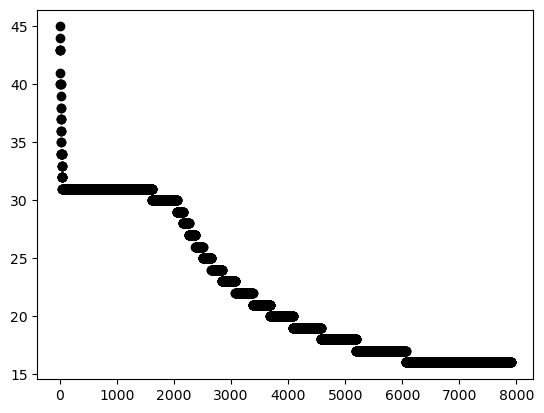

In [29]:
import matplotlib.pyplot as pyplot

def plot_lengths(unitigs):
    unitig_lengths = [len(unitig) for unitig in unitigs]
    unitig_lengths.sort(reverse = True)
    
    pyplot.plot(unitig_lengths, 'o', color='black') # We plot list
    
plot_lengths(unitigs)

# 4. Error handling

**The above assembly results are quite dismal: unitigs are only slightly longer than the value of `k` used in the assembly!**

On second thought, recall that the reads contain sequencing errors: these introduce erroneous $k$-mers in the graph, and thus introduce branches inside unitigs. 

We'll now see how to deal with these.

## 4.1. Validation

To convince us of this fact, suppose for the purpose of this assignment that we also have available the *true genome* from which the reads were sequenced. **This is not true in practice, since we are actually trying to figure out this genome!** However, development and evaluation of genome assemblers usually follows this pattern (since we now have many available genomes), as a validation and benckmarking step.

Let's now align all unitigs to this true genome, and see how many actually align. The ones that do not thus contain $k$-mers with errors.

First, we read the true genome from the FASTA file `data/genome.fasta`.

In [30]:
def get_genome(filePath):
    genome = str()
    
    fastaFile = open(filePath, 'r') 
    
    fastaFile.readline() # Read header line
    fastaLines = fastaFile.readlines()
    fastaFile.close()

    for line in fastaLines:
        genome += line.strip().upper()
    
    return genome

trueGenome = get_genome('data/genome.fasta')

# Print the first 200 characters of trueGenome, for sanity check
print(trueGenome[:200])

CGGACACACAAAAAGAATGAAGGATTTTGAATCTTTATTGTGTGCGAGTAACTACGAGGAAGATTAAAGATTTTCCTCTCATTGAAATTGAAATTGAGATTCTAATCTCGACGGATCGATCCCCAATACCAACACTGAGAATTGGCCTGAAGAAGTCATCTGCTCCTTGGCAAAACCAAGAGCAGGCCCAAAGGGCCATT


Since we cannot call an actual read aligner in this Jupyter notebook, we will use the Python function `str.find(substring)`, which returns the position of the first occurence of ``substring`` inside ``str``, or ``-1`` if no such occurrence exists.

In [36]:
def align(genome, unitigs):
    notFound = 0 # This will store the number of unitigs not found in genome

    for unitig in unitigs:
        pos = genome.find(unitig)
        if pos == -1:
            notFound += 1
    
    return notFound
    
notFound = align(trueGenome, unitigs)

print('Unitigs not aligning:', notFound)
print('Proportion of unitigs not aligning:', notFound / len(unitigs))

Unitigs not aligning: 3604
Proportion of unitigs not aligning: 0.4559139784946237


**Wow, a signficant amount of unitigs do not align!** This is a strong indication that the reads contain errors, and that we must filter these out. 

## 4.2. Correction

The main error correction idea used in the assembly field is to decide on an `abundance` threshold (which will depend on read coverage and error rate), such that any $k$-mer which appears less than `abundance` times in the reads is not added as a node in the de Bruijn graph. 

We will now implement this approach and will again assemble unitigs, just as before, in this new de Bruijn graph. We will then compare the unitig lengths before and after this correction step. 

Consider the following analogue of `build_dbGraph_from_reads`, which now takes into account also the parameter `abundance`.

In [34]:
# The abundance threshold we will use throughout
a = 3

def build_dbGraph_from_reads_abundance(reads, order, abundance):
    dbGraph = dict()

    count = dict()
    for read in reads:
        for i in range(len(read) - (order - 1)):
            kmer = read[i:i+order]
            count[kmer] = count.get(kmer,0) + 1 # count.get(kmer,0) returns count[kmer], if kmer is a key in count, and 0 otherwise
    for kmer in count:
        if count[kmer] >= abundance:
            dbGraph[kmer] = abundance
    
    return dbGraph

corrected_dbGraph = build_dbGraph_from_reads_abundance(reads, k, a)
print('Nodes in the graph:', len(corrected_dbGraph))

Nodes in the graph: 18883


<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 11</strong></h3>

Explain how the above code works.

---
#### build_dbGraph_from_reads_abundance
First, two dictionaries, dbGraph and count, are intitalized. Then the readings in list reads (given as a parameter) are looped over. In the second for loop, from every reading all possible kmers of desired order (given as a parameter) are constructed, and a record of how many times each kmer has popped up is updated in dictionary count on each round. Finally, the count dictionary is looped through and only those kmers that have count at least as big as the abundance (given as a parameter) are added in the dbGraph dictionary (as keys with the abundance as value).

---

Let's now assemble the unitigs of `corrected_dbGraph` and compute the statistics about its unitigs.

Mean unitig length: 570.6470588235294
Median unitig length: 16.0
Min unitig length: 16
Max unitig length: 2904
Number of unitigs: 34
Total length of unitigs: 19402
N50 value: 2518
Unitigs not aligning: 8


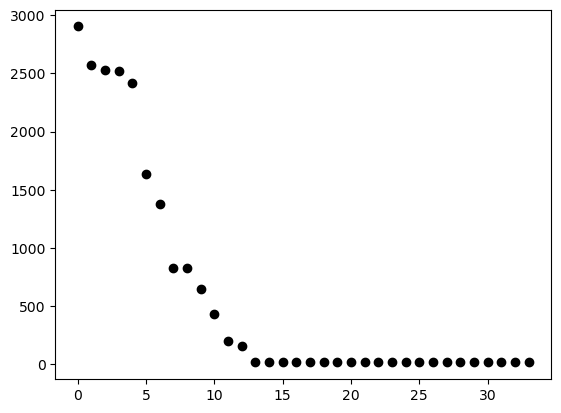

In [39]:
corrected_unitigs = assemble_unitigs(corrected_dbGraph)

print_basic_statistics(corrected_unitigs)
print_N50(corrected_unitigs)
plot_lengths(corrected_unitigs)
print('Unitigs not aligning:', align(trueGenome, corrected_unitigs))

**Things are now significatly different!**

We managed to obtain only **34 unitigs**, and half of all their total length comes from unitigs of **length 2518 or more (N50 metric)**. Moreover, only **8** of them do not align to the true benchmark genome. 

**A simple correction approach makes such a big difference.**

### Which `k` and `abundance` to choose?

Finally, let's consider the tradeoff between `k` and `abundance`. The code below assembles the unitigs of the de Bruijn graph for several values of `k` and several values of `a`. For each pair `(k,a)`, it computes how many unitigs are assembled, and how many of them do not align to the true reference.

<span style="color:red"><strong>Run the code below and wait several seconds for it to finish!</strong></span>

In [40]:
import pandas
from IPython.display import display

results = list()
abundance_values = [1,2,3,4,5,6]
k_values = [15,21,27,39,51]

for a_value in abundance_values:
    a_results = list()
    for k_value in k_values:
        print(f'Getting results for a:{a_value}, k:{k_value}. Please wait ...')
        temp_dbGraph = build_dbGraph_from_reads_abundance(reads, k_value, a_value)
        temp_unitigs = assemble_unitigs(temp_dbGraph)
        temp_notFound = align(trueGenome, temp_unitigs)
        a_results.append((len(temp_unitigs),temp_notFound))
    results.append(a_results)

row_labels = [f'a:{a_value}' for a_value in abundance_values]
col_labels = [f'k:{k_value}' for k_value in k_values]
   
print('\nDone, here are the results. The format of each cell is (#unitigs, #unitigs not aligning).\n')
display(pandas.DataFrame(data=results, index=row_labels, columns=col_labels, dtype=None, copy=False))

Getting results for a:1, k:15. Please wait ...
Getting results for a:1, k:21. Please wait ...
Getting results for a:1, k:27. Please wait ...
Getting results for a:1, k:39. Please wait ...
Getting results for a:1, k:51. Please wait ...
Getting results for a:2, k:15. Please wait ...
Getting results for a:2, k:21. Please wait ...
Getting results for a:2, k:27. Please wait ...
Getting results for a:2, k:39. Please wait ...
Getting results for a:2, k:51. Please wait ...
Getting results for a:3, k:15. Please wait ...
Getting results for a:3, k:21. Please wait ...
Getting results for a:3, k:27. Please wait ...
Getting results for a:3, k:39. Please wait ...
Getting results for a:3, k:51. Please wait ...
Getting results for a:4, k:15. Please wait ...
Getting results for a:4, k:21. Please wait ...
Getting results for a:4, k:27. Please wait ...
Getting results for a:4, k:39. Please wait ...
Getting results for a:4, k:51. Please wait ...
Getting results for a:5, k:15. Please wait ...
Getting resul

,k:15,k:21,k:27,k:39,k:51
a:1,"(7905, 3604)","(7439, 3418)","(7050, 3300)","(6462, 3229)","(5723, 3096)"
a:2,"(219, 81)","(168, 69)","(147, 63)","(115, 59)","(88, 53)"
a:3,"(34, 8)","(7, 2)","(1, 0)","(2, 0)","(21, 0)"
a:4,"(33, 8)","(7, 2)","(1, 0)","(2, 0)","(103, 0)"
a:5,"(33, 8)","(7, 2)","(2, 0)","(27, 0)","(285, 0)"
a:6,"(33, 8)","(8, 2)","(3, 0)","(111, 0)","(482, 0)"


<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 12</strong></h3>

Explain the results of the above table. Where are the best results, where are the worse results, **why**? 

How would you choose the values of `k` and `a` in practice (when you don't have the true genome to guide the choice)?

---
#### Order and abundances testing results
What we basically aim for, is as few unitigs as possible, given the results are also accurate, meaning the number of non-aligning unitigs is low. With that in mind, the the best possible result (1, 0) is produced by k=27 and a=3 or a=4.

The worst results seem to be produced by not considering the possibility of sequencing errors, i.e. with a=1. Increaasing k does not help decreasing the number of unaligned unitigs very much and overall the influence of k is less significant in affecting the results. For a, it seems like after a certain value (here a=3) the number of unaligned unitig does not decrease anymore. In case of k, there is not such a simple effect but there seems to be a point, after which the number of unitigs starts to increase again.

In practice, we only have the number of unitigs available, so we cant rely on the aligning results. In our example, it seems that the number of unalignments is at its lowest when the number of unitigs reaches its lower value as well. (Well, of course with one unitig only the number of unalignmets is zero.) With these results only, I would simply try to minimize the number of unitigs. However, I would calculate some other results, like N50, to get a bit more information out of the alignment.

The code below produces similar table but with (#unitigs, N50) pairs as results. From there we can see that minumizing the number of unitigs and maximazing the N50 value would be a good approach.

---

In [42]:
import pandas
from IPython.display import display

def get_N50(unitigs):
    sorted_unitigs = sorted(unitigs, reverse = True, key=lambda unitig: len(unitig)) # the list of unitigs is now sorted by length from large to small

    totalLength = sum([len(unitig) for unitig in sorted_unitigs])

    partialLength = 0
    for unitig in sorted_unitigs:
        partialLength += len(unitig)
        if partialLength >= 0.5 * totalLength:
            return len(unitig)

results = list()
abundance_values = [1,2,3,4,5,6]
k_values = [15,21,27,39,51]

for a_value in abundance_values:
    a_results = list()
    for k_value in k_values:
        print(f'Getting results for a:{a_value}, k:{k_value}. Please wait ...')
        temp_dbGraph = build_dbGraph_from_reads_abundance(reads, k_value, a_value)
        temp_unitigs = assemble_unitigs(temp_dbGraph)
        temp_N50 = get_N50(temp_unitigs)
        a_results.append((len(temp_unitigs),temp_N50))
    results.append(a_results)

row_labels = [f'a:{a_value}' for a_value in abundance_values]
col_labels = [f'k:{k_value}' for k_value in k_values]
   
print('\nDone, here are the results. The format of each cell is (#unitigs, N50).\n')
display(pandas.DataFrame(data=results, index=row_labels, columns=col_labels, dtype=None, copy=False))

Getting results for a:1, k:15. Please wait ...
Getting results for a:1, k:21. Please wait ...
Getting results for a:1, k:27. Please wait ...
Getting results for a:1, k:39. Please wait ...
Getting results for a:1, k:51. Please wait ...
Getting results for a:2, k:15. Please wait ...
Getting results for a:2, k:21. Please wait ...
Getting results for a:2, k:27. Please wait ...
Getting results for a:2, k:39. Please wait ...
Getting results for a:2, k:51. Please wait ...
Getting results for a:3, k:15. Please wait ...
Getting results for a:3, k:21. Please wait ...
Getting results for a:3, k:27. Please wait ...
Getting results for a:3, k:39. Please wait ...
Getting results for a:3, k:51. Please wait ...
Getting results for a:4, k:15. Please wait ...
Getting results for a:4, k:21. Please wait ...
Getting results for a:4, k:27. Please wait ...
Getting results for a:4, k:39. Please wait ...
Getting results for a:4, k:51. Please wait ...
Getting results for a:5, k:15. Please wait ...
Getting resul

,k:15,k:21,k:27,k:39,k:51
a:1,"(7905, 23)","(7439, 30)","(7050, 37)","(6462, 51)","(5723, 65)"
a:2,"(219, 365)","(168, 399)","(147, 410)","(115, 470)","(88, 715)"
a:3,"(34, 2518)","(7, 10663)","(1, 18907)","(2, 9548)","(21, 1184)"
a:4,"(33, 2518)","(7, 10658)","(1, 18901)","(2, 9545)","(103, 309)"
a:5,"(33, 2518)","(7, 10653)","(2, 18890)","(27, 1550)","(285, 133)"
a:6,"(33, 2518)","(8, 10643)","(3, 11270)","(111, 356)","(482, 80)"
